<a href="https://colab.research.google.com/github/keikunimasa/ISIC-SkinCanser-Detection/blob/main/ISIC_2024_Borrowed_179LB_Tabular_OOF_ImageNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'isic-2024-challenge:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F63056%2F9094797%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240811%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240811T064702Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D81dcea099d938f15ab60721638088ad6ca75489d0b463eb0e934693115fa31c3fab1534872f3bb8821eeceac4392b15a03bff9a0b26ff50810e83fc013eaedc7b85a3a05904af824bc728247be15d9d2ff735a8c7cf20da8f7ca5b555ec68dbc55442fb3bf85bf6cbae00b822d59766337463a3eb5c2e29fbcc5d97e89343efa9d35df3f9dd4ad92e160b7309275778eea99dcb34b10e57f5a8110880c21a1b1c7313dbb80b17d8850f00ae0329c562e3dcbb98c5062f855b988299f8658b3799e377eaa5f0b022d52c002ea0ef5fab2934649e1a2001ef9d0c6e2a35300097e6ac3fc7e53cf835e189c7bb74534ad10c6a8b304a9e719ef2575bcbdeab3fcb6'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2148525604 bytes downloaded
Downloaded and uncompressed: isic-2024-challenge
Data source import complete.


In [8]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## The bulk of this notebook is copied from the excellent: https://www.kaggle.com/code/greysky/isic-2024-only-tabular-data
### I add to this:
* Merge OOF (out-of-CV-fold) ImageNets predictions into the train set / use as a feature ("imagenet_predict")
* Same folds defined in ImageNet predictions are re-used in tabular training to avoid data-leakage

## See https://www.kaggle.com/code/richolson/isic-2024-imagenet-train-oof-preds-public for a public example of how to train an ImageNet / generate OOF predictions
* That notebook is a de-optimized version of my private imagenet notebook
* Doesn't do much as-is - but is a handful of tweaks away from performing well

### Version 1 of this notebook (.181 LB) uses OOF predictions and ImageNets that are private (sorry!)

### Version 3 of this notebook uses the public OOF predictions and ImageNet
* You should be able to submit it - but no promises on LB score

In [3]:
!pip install polars
!pip install optuna
!pip install catboost
!pip install xgboost
!pip install lightgbm
!pip install imblearn

import os
from pathlib import Path

import numpy as np
import pandas as pd
import polars as pl

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import lightgbm as lgb
import catboost as cb
import xgboost as xgb

import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.5/31.5 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.0/616.0 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 2.2 MB/s eta 0:00:00


In [23]:
root = Path('/kaggle/input/isic-2024-challenge')

train_path = root / 'train-metadata.csv'
test_path = root / 'test-metadata.csv'
subm_path = root / 'sample_submission.csv'

id_col = 'isic_id'
target_col = 'target'
group_col = 'patient_id'

err = 1e-5
sampling_ratio = 0.01
seed = 42

num_cols = [
    'age_approx',                        # Approximate age of patient at time of imaging.
    'clin_size_long_diam_mm',            # Maximum diameter of the lesion (mm).+
    'tbp_lv_A',                          # A inside  lesion.+
    'tbp_lv_Aext',                       # A outside lesion.+
    'tbp_lv_B',                          # B inside  lesion.+
    'tbp_lv_Bext',                       # B outside lesion.+
    'tbp_lv_C',                          # Chroma inside  lesion.+
    'tbp_lv_Cext',                       # Chroma outside lesion.+
    'tbp_lv_H',                          # Hue inside the lesion; calculated as the angle of A* and B* in LAB* color space. Typical values range from 25 (red) to 75 (brown).+
    'tbp_lv_Hext',                       # Hue outside lesion.+
    'tbp_lv_L',                          # L inside lesion.+
    'tbp_lv_Lext',                       # L outside lesion.+
    'tbp_lv_areaMM2',                    # Area of lesion (mm^2).+
    'tbp_lv_area_perim_ratio',           # Border jaggedness, the ratio between lesions perimeter and area. Circular lesions will have low values; irregular shaped lesions will have higher values. Values range 0-10.+
    'tbp_lv_color_std_mean',             # Color irregularity, calculated as the variance of colors within the lesion's boundary.
    'tbp_lv_deltaA',                     # Average A contrast (inside vs. outside lesion).+
    'tbp_lv_deltaB',                     # Average B contrast (inside vs. outside lesion).+
    'tbp_lv_deltaL',                     # Average L contrast (inside vs. outside lesion).+
    'tbp_lv_deltaLB',                    #
    'tbp_lv_deltaLBnorm',                # Contrast between the lesion and its immediate surrounding skin. Low contrast lesions tend to be faintly visible such as freckles; high contrast lesions tend to be those with darker pigment. Calculated as the average delta LB of the lesion relative to its immediate background in LAB* color space. Typical values range from 5.5 to 25.+
    'tbp_lv_eccentricity',               # Eccentricity.+
    'tbp_lv_minorAxisMM',                # Smallest lesion diameter (mm).+
    'tbp_lv_nevi_confidence',            # Nevus confidence score (0-100 scale) is a convolutional neural network classifier estimated probability that the lesion is a nevus. The neural network was trained on approximately 57,000 lesions that were classified and labeled by a dermatologist.+,++
    'tbp_lv_norm_border',                # Border irregularity (0-10 scale); the normalized average of border jaggedness and asymmetry.+
    'tbp_lv_norm_color',                 # Color variation (0-10 scale); the normalized average of color asymmetry and color irregularity.+
    'tbp_lv_perimeterMM',                # Perimeter of lesion (mm).+
    'tbp_lv_radial_color_std_max',       # Color asymmetry, a measure of asymmetry of the spatial distribution of color within the lesion. This score is calculated by looking at the average standard deviation in LAB* color space within concentric rings originating from the lesion center. Values range 0-10.+
    'tbp_lv_stdL',                       # Standard deviation of L inside  lesion.+
    'tbp_lv_stdLExt',                    # Standard deviation of L outside lesion.+
    'tbp_lv_symm_2axis',                 # Border asymmetry; a measure of asymmetry of the lesion's contour about an axis perpendicular to the lesion's most symmetric axis. Lesions with two axes of symmetry will therefore have low scores (more symmetric), while lesions with only one or zero axes of symmetry will have higher scores (less symmetric). This score is calculated by comparing opposite halves of the lesion contour over many degrees of rotation. The angle where the halves are most similar identifies the principal axis of symmetry, while the second axis of symmetry is perpendicular to the principal axis. Border asymmetry is reported as the asymmetry value about this second axis. Values range 0-10.+
    'tbp_lv_symm_2axis_angle',           # Lesion border asymmetry angle.+
    'tbp_lv_x',                          # X-coordinate of the lesion on 3D TBP.+
    'tbp_lv_y',                          # Y-coordinate of the lesion on 3D TBP.+
    'tbp_lv_z',                          # Z-coordinate of the lesion on 3D TBP.+
]

new_num_cols = [
    'lesion_size_ratio',             # tbp_lv_minorAxisMM      / clin_size_long_diam_mm
    'lesion_shape_index',            # tbp_lv_areaMM2          / tbp_lv_perimeterMM **2
    'hue_contrast',                  # tbp_lv_H                - tbp_lv_Hext              abs
    'luminance_contrast',            # tbp_lv_L                - tbp_lv_Lext              abs
    'lesion_color_difference',       # tbp_lv_deltaA **2       + tbp_lv_deltaB **2 + tbp_lv_deltaL **2  sqrt
    'border_complexity',             # tbp_lv_norm_border      + tbp_lv_symm_2axis
    'color_uniformity',              # tbp_lv_color_std_mean   / tbp_lv_radial_color_std_max

    'position_distance_3d',          # tbp_lv_x **2 + tbp_lv_y **2 + tbp_lv_z **2  sqrt
    'perimeter_to_area_ratio',       # tbp_lv_perimeterMM      / tbp_lv_areaMM2
    'area_to_perimeter_ratio',       # tbp_lv_areaMM2          / tbp_lv_perimeterMM
    'lesion_visibility_score',       # tbp_lv_deltaLBnorm      + tbp_lv_norm_color
    'symmetry_border_consistency',   # tbp_lv_symm_2axis       * tbp_lv_norm_border
    'consistency_symmetry_border',   # tbp_lv_symm_2axis       * tbp_lv_norm_border / (tbp_lv_symm_2axis + tbp_lv_norm_border)

    'color_consistency',             # tbp_lv_stdL             / tbp_lv_Lext
    'consistency_color',             # tbp_lv_stdL*tbp_lv_Lext / tbp_lv_stdL + tbp_lv_Lext
    'size_age_interaction',          # clin_size_long_diam_mm  * age_approx
    'hue_color_std_interaction',     # tbp_lv_H                * tbp_lv_color_std_mean
    'lesion_severity_index',         # tbp_lv_norm_border      + tbp_lv_norm_color + tbp_lv_eccentricity / 3
    'shape_complexity_index',        # border_complexity       + lesion_shape_index
    'color_contrast_index',          # tbp_lv_deltaA + tbp_lv_deltaB + tbp_lv_deltaL + tbp_lv_deltaLBnorm

    'log_lesion_area',               # tbp_lv_areaMM2          + 1  np.log
    'normalized_lesion_size',        # clin_size_long_diam_mm  / age_approx
    'mean_hue_difference',           # tbp_lv_H                + tbp_lv_Hext    / 2
    'std_dev_contrast',              # tbp_lv_deltaA **2 + tbp_lv_deltaB **2 + tbp_lv_deltaL **2   / 3  np.sqrt
    'color_shape_composite_index',   # tbp_lv_color_std_mean   + bp_lv_area_perim_ratio + tbp_lv_symm_2axis   / 3
    'lesion_orientation_3d',         # tbp_lv_y                , tbp_lv_x  np.arctan2
    'overall_color_difference',      # tbp_lv_deltaA           + tbp_lv_deltaB + tbp_lv_deltaL   / 3

    'symmetry_perimeter_interaction',# tbp_lv_symm_2axis       * tbp_lv_perimeterMM
    'comprehensive_lesion_index',    # tbp_lv_area_perim_ratio + tbp_lv_eccentricity + bp_lv_norm_color + tbp_lv_symm_2axis   / 4
    'color_variance_ratio',          # tbp_lv_color_std_mean   / tbp_lv_stdLExt
    'border_color_interaction',      # tbp_lv_norm_border      * tbp_lv_norm_color
    'border_color_interaction_2',
    'size_color_contrast_ratio',     # clin_size_long_diam_mm  / tbp_lv_deltaLBnorm
    'age_normalized_nevi_confidence',# tbp_lv_nevi_confidence  / age_approx
    'age_normalized_nevi_confidence_2',
    'color_asymmetry_index',         # tbp_lv_symm_2axis       * tbp_lv_radial_color_std_max

    'volume_approximation_3d',       # tbp_lv_areaMM2          * sqrt(tbp_lv_x**2 + tbp_lv_y**2 + tbp_lv_z**2)
    'color_range',                   # abs(tbp_lv_L - tbp_lv_Lext) + abs(tbp_lv_A - tbp_lv_Aext) + abs(tbp_lv_B - tbp_lv_Bext)
    'shape_color_consistency',       # tbp_lv_eccentricity     * tbp_lv_color_std_mean
    'border_length_ratio',           # tbp_lv_perimeterMM      / pi * sqrt(tbp_lv_areaMM2 / pi)
    'age_size_symmetry_index',       # age_approx              * clin_size_long_diam_mm * tbp_lv_symm_2axis
    'index_age_size_symmetry',       # age_approx              * tbp_lv_areaMM2 * tbp_lv_symm_2axis
]

cat_cols = ['sex', 'anatom_site_general', 'tbp_tile_type', 'tbp_lv_location', 'tbp_lv_location_simple', 'attribution']
norm_cols = [f'{col}_patient_norm' for col in num_cols + new_num_cols]

special_cols = ['count_per_patient']
feature_cols = num_cols + new_num_cols + cat_cols + norm_cols + special_cols

In [24]:
def read_data(path):
    return (
        pl.read_csv(path)
        .with_columns(
            pl.col('age_approx').cast(pl.String).replace('NA', np.nan).cast(pl.Float64),
        )
        .with_columns(
            pl.col(pl.Float64).fill_nan(pl.col(pl.Float64).median()), # You may want to impute test data with train
        )
        .with_columns(
            lesion_size_ratio              = pl.col('tbp_lv_minorAxisMM') / pl.col('clin_size_long_diam_mm'),
            lesion_shape_index             = pl.col('tbp_lv_areaMM2') / (pl.col('tbp_lv_perimeterMM') ** 2),
            hue_contrast                   = (pl.col('tbp_lv_H') - pl.col('tbp_lv_Hext')).abs(),
            luminance_contrast             = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs(),
            lesion_color_difference        = (pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2).sqrt(),
            border_complexity              = pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_symm_2axis'),
            color_uniformity               = pl.col('tbp_lv_color_std_mean') / (pl.col('tbp_lv_radial_color_std_max') + err),
        )
        .with_columns(
            position_distance_3d           = (pl.col('tbp_lv_x') ** 2 + pl.col('tbp_lv_y') ** 2 + pl.col('tbp_lv_z') ** 2).sqrt(),
            perimeter_to_area_ratio        = pl.col('tbp_lv_perimeterMM') / pl.col('tbp_lv_areaMM2'),
            area_to_perimeter_ratio        = pl.col('tbp_lv_areaMM2') / pl.col('tbp_lv_perimeterMM'),
            lesion_visibility_score        = pl.col('tbp_lv_deltaLBnorm') + pl.col('tbp_lv_norm_color'),
            combined_anatomical_site       = pl.col('anatom_site_general') + '_' + pl.col('tbp_lv_location'),
            symmetry_border_consistency    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border'),
            consistency_symmetry_border    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border') / (pl.col('tbp_lv_symm_2axis') + pl.col('tbp_lv_norm_border')),
        )
        .with_columns(
            color_consistency              = pl.col('tbp_lv_stdL') / pl.col('tbp_lv_Lext'),
            consistency_color              = pl.col('tbp_lv_stdL') * pl.col('tbp_lv_Lext') / (pl.col('tbp_lv_stdL') + pl.col('tbp_lv_Lext')),
            size_age_interaction           = pl.col('clin_size_long_diam_mm') * pl.col('age_approx'),
            hue_color_std_interaction      = pl.col('tbp_lv_H') * pl.col('tbp_lv_color_std_mean'),
            lesion_severity_index          = (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_eccentricity')) / 3,
            shape_complexity_index         = pl.col('border_complexity') + pl.col('lesion_shape_index'),
            color_contrast_index           = pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL') + pl.col('tbp_lv_deltaLBnorm'),
        )
        .with_columns(
            log_lesion_area                = (pl.col('tbp_lv_areaMM2') + 1).log(),
            normalized_lesion_size         = pl.col('clin_size_long_diam_mm') / pl.col('age_approx'),
            mean_hue_difference            = (pl.col('tbp_lv_H') + pl.col('tbp_lv_Hext')) / 2,
            std_dev_contrast               = ((pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2) / 3).sqrt(),
            color_shape_composite_index    = (pl.col('tbp_lv_color_std_mean') + pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_symm_2axis')) / 3,
            lesion_orientation_3d          = pl.arctan2(pl.col('tbp_lv_y'), pl.col('tbp_lv_x')),
            overall_color_difference       = (pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL')) / 3,
        )
        .with_columns(
            symmetry_perimeter_interaction = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_perimeterMM'),
            comprehensive_lesion_index     = (pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_eccentricity') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_symm_2axis')) / 4,
            color_variance_ratio           = pl.col('tbp_lv_color_std_mean') / pl.col('tbp_lv_stdLExt'),
            border_color_interaction       = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color'),
            border_color_interaction_2     = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color') / (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color')),
            size_color_contrast_ratio      = pl.col('clin_size_long_diam_mm') / pl.col('tbp_lv_deltaLBnorm'),
            age_normalized_nevi_confidence = pl.col('tbp_lv_nevi_confidence') / pl.col('age_approx'),
            age_normalized_nevi_confidence_2 = (pl.col('clin_size_long_diam_mm')**2 + pl.col('age_approx')**2).sqrt(),
            color_asymmetry_index          = pl.col('tbp_lv_radial_color_std_max') * pl.col('tbp_lv_symm_2axis'),
        )
        .with_columns(
            volume_approximation_3d        = pl.col('tbp_lv_areaMM2') * (pl.col('tbp_lv_x')**2 + pl.col('tbp_lv_y')**2 + pl.col('tbp_lv_z')**2).sqrt(),
            color_range                    = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs() + (pl.col('tbp_lv_A') - pl.col('tbp_lv_Aext')).abs() + (pl.col('tbp_lv_B') - pl.col('tbp_lv_Bext')).abs(),
            shape_color_consistency        = pl.col('tbp_lv_eccentricity') * pl.col('tbp_lv_color_std_mean'),
            border_length_ratio            = pl.col('tbp_lv_perimeterMM') / (2 * np.pi * (pl.col('tbp_lv_areaMM2') / np.pi).sqrt()),
            age_size_symmetry_index        = pl.col('age_approx') * pl.col('clin_size_long_diam_mm') * pl.col('tbp_lv_symm_2axis'),
            index_age_size_symmetry        = pl.col('age_approx') * pl.col('tbp_lv_areaMM2') * pl.col('tbp_lv_symm_2axis'),
        )
        .with_columns(
            ((pl.col(col) - pl.col(col).mean().over('patient_id')) / (pl.col(col).std().over('patient_id') + err)).alias(f'{col}_patient_norm') for col in (num_cols + new_num_cols)
        )
        .with_columns(
            count_per_patient = pl.col('isic_id').count().over('patient_id'),
        )
        .with_columns(
            pl.col(cat_cols).cast(pl.Categorical),
        )
        .to_pandas()
        .set_index(id_col)
    )

In [25]:
def preprocess(df_train, df_test):
    global cat_cols

    encoder = OneHotEncoder(sparse_output=False, dtype=np.int32, handle_unknown='ignore')
    encoder.fit(df_train[cat_cols])

    new_cat_cols = [f'onehot_{i}' for i in range(len(encoder.get_feature_names_out()))]

    df_train[new_cat_cols] = encoder.transform(df_train[cat_cols])
    df_train[new_cat_cols] = df_train[new_cat_cols].astype('category')

    df_test[new_cat_cols] = encoder.transform(df_test[cat_cols])
    df_test[new_cat_cols] = df_test[new_cat_cols].astype('category')

    for col in cat_cols:
        feature_cols.remove(col)

    feature_cols.extend(new_cat_cols)
    cat_cols = new_cat_cols

    return df_train, df_test

In [26]:
def custom_metric(estimator, X, y_true):
    y_hat = estimator.predict_proba(X)[:, 1]
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)

    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])

    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)

    return partial_auc

### Data Read & Feature Engineering

In [27]:
import gc
gc.collect()
df_train = read_data(train_path)
df_test = read_data(test_path)
df_subm = pd.read_csv(subm_path, index_col=id_col)

df_train, df_test = preprocess(df_train, df_test)
df_train.describe()

,target,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,...,age_normalized_nevi_confidence_patient_norm,age_normalized_nevi_confidence_2_patient_norm,color_asymmetry_index_patient_norm,volume_approximation_3d_patient_norm,color_range_patient_norm,shape_color_consistency_patient_norm,border_length_ratio_patient_norm,age_size_symmetry_index_patient_norm,index_age_size_symmetry_patient_norm,count_per_patient
count,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,...,4.010540e+05,4.010540e+05,4.010540e+05,4.010540e+05,4.010540e+05,4.010540e+05,4.010540e+05,4.010540e+05,4.010540e+05,401059.000000
mean,0.000980,58.026849,3.930827,19.974007,14.919247,28.281706,26.913015,34.786341,30.921279,54.653689,...,-6.297467e-17,-5.569862e-14,6.895411e-17,-6.066261e-17,-6.134737e-16,-1.260025e-16,2.985649e-16,-1.261442e-17,-2.933916e-17,1142.532647
std,0.031288,13.549664,1.743068,3.999489,3.529384,5.278676,4.482994,5.708469,4.829345,5.520849,...,9.986874e-01,9.986488e-01,9.986615e-01,9.987076e-01,9.987054e-01,9.986881e-01,9.986338e-01,9.987073e-01,9.987075e-01,1666.379678
min,0.000000,5.000000,1.000000,-2.487115,-9.080269,-0.730989,9.237066,3.054228,11.846520,-1.574164,...,-5.802969e+00,-3.344933e+01,-2.628086e+00,-2.006196e+00,-3.661765e+00,-2.431412e+00,-2.853321e+00,-1.924727e+00,-1.971400e+00,1.000000
25%,0.000000,50.000000,2.840000,17.330821,12.469740,24.704372,23.848125,31.003148,27.658285,51.566273,...,-6.720920e-01,-4.617431e-01,-5.788070e-01,-5.088167e-01,-6.979457e-01,-6.514565e-01,-6.960858e-01,-6.100199e-01,-4.784476e-01,352.000000
50%,0.000000,60.000000,3.370000,19.801910,14.713930,28.171570,26.701704,34.822580,30.804893,55.035632,...,-2.960885e-01,-2.745153e-01,-2.087698e-01,-2.738855e-01,-1.366203e-01,-1.880408e-01,-2.560886e-01,-2.775833e-01,-2.902077e-01,630.000000
75%,0.000000,70.000000,4.380000,22.304628,17.137175,31.637429,29.679913,38.430298,33.963868,58.298184,...,7.314047e-01,7.117264e-02,3.276235e-01,1.360080e-01,5.593789e-01,4.447693e-01,4.316315e-01,2.761594e-01,7.893950e-02,1132.000000
max,1.000000,85.000000,28.400000,48.189610,37.021680,54.306900,48.372700,58.765170,54.305290,105.875784,...,1.302002e+01,2.310924e+01,1.508117e+01,1.993806e+01,1.096295e+01,1.208560e+01,8.741093e+00,1.623901e+01,2.205425e+01,9184.000000


In [34]:
nan_counts = df_train.isna().sum()
nan_cols = nan_counts[nan_counts > 0]
nan_ranking = nan_cols.rank(ascending=False)
nan_table = pd.DataFrame({
    "col name": nan_cols.index,
    "count of nan": nan_cols.values,
    "col ranking": nan_ranking.values
})
print(nan_table)

test = df_train
test = test.dropna(axis=0)
print(test.size)
print(df_train.size)

                                col name  count of nan  col ranking
0                age_approx_patient_norm             5         38.5
1    clin_size_long_diam_mm_patient_norm             5         38.5
2                  tbp_lv_A_patient_norm             5         38.5
3               tbp_lv_Aext_patient_norm             5         38.5
4                  tbp_lv_B_patient_norm             5         38.5
..                                   ...           ...          ...
71              color_range_patient_norm             5         38.5
72  shape_color_consistency_patient_norm             5         38.5
73      border_length_ratio_patient_norm             5         38.5
74  age_size_symmetry_index_patient_norm             5         38.5
75  index_age_size_symmetry_patient_norm             5         38.5

[76 rows x 3 columns]
88632934
88634039


In [35]:
# prompt: find most usable feature from df_train

from sklearn.feature_selection import SelectKBest, chi2

# Assuming 'target' is the name of your target variable column
X = test.drop('target', axis=1)
y = test['target']

# Initialize SelectKBest with chi-squared test
selector = SelectKBest(chi2, k=1)  # Select the top 1 feature

# Fit the selector to the data
selector.fit(X, y)

# Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = X.columns[selected_feature_indices]

print("Most usable feature:", selected_feature_names[0])


ValueError: could not convert string to float: 'IP_1235828'

# Add in OOF imagenet preds

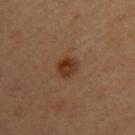

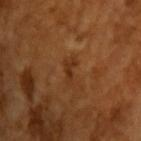

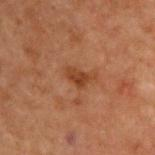

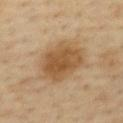

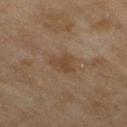

In [40]:
import os
import random
from IPython.display import Image, display

# **Verify the path to your image folder**
image_folder = '/kaggle/input/isic-2024-challenge/train-image/image'

# **List all files in the directory, not just .jpg files**
image_files = [f for f in os.listdir(image_folder)]

# **Check if the directory is empty**
if not image_files:
    print("No files found in the directory. Please check the path.")
else:
    # Select 5 random images (or fewer if there are less than 5 images)
    num_images_to_select = min(5, len(image_files))
    selected_images = random.sample(image_files, num_images_to_select)

    # Display the images
    for image_file in selected_images:
        image_path = os.path.join(image_folder, image_file)
        # **Check if the file is a jpg image before displaying**
        if image_file.lower().endswith('.jpg'):
            display(Image(filename=image_path))

## implementing image analysis model
form this section, based on [ISIC] Pytorch Training Baseline (Image only)

In [44]:
!pip install torcheval
!pip install colorama
!pip install timm
!pip install albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 878.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.7/171.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 22.7 MB/s eta 0:00:00


In [45]:

import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision
from torcheval.metrics.functional import binary_auroc

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold

# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

### Training Config

In [46]:
CONFIG = {
    "seed": 42,
    "epochs": 50,
    "img_size": 384,
    "model_name": "tf_efficientnet_b0_ns",
    "checkpoint_path" : "/kaggle/input/tf-efficientnet/pytorch/tf-efficientnet-b0/1/tf_efficientnet_b0_aa-827b6e33.pth",
    "train_batch_size": 32,
    "valid_batch_size": 64,
    "learning_rate": 1e-4,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 500,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

In [ ]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(CONFIG['seed'])


In [89]:
ROOT_DIR = "/kaggle/input/isic-2024-challenge"
TRAIN_DIR = f'{ROOT_DIR}/train-image/image'
def get_train_file_path(image_id):
    return f"{TRAIN_DIR}/{image_id}.jpg"

In [90]:
train_images = sorted(glob.glob(f"{TRAIN_DIR}/*.jpg"))
df = pd.read_csv(f"{ROOT_DIR}/train-metadata.csv")

print("        df.shape, # of positive cases, # of patients")
print("original>", df.shape, df.target.sum(), df["patient_id"].unique().shape)

df_positive = df[df["target"] == 1].reset_index(drop=True)
df_negative = df[df["target"] == 0].reset_index(drop=True)

df = pd.concat([df_positive, df_negative.iloc[:df_positive.shape[0]*20, :]])  # positive:negative = 1:20
print("filtered>", df.shape, df.target.sum(), df["patient_id"].unique().shape)

df['file_path'] = df['isic_id'].apply(get_train_file_path)
df = df[ df["file_path"].isin(train_images) ].reset_index(drop=True)
df

        df.shape, # of positive cases, # of patients
original> (401059, 55) 393 (1042,)
filtered> (8253, 55) 393 (950,)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,file_path
0,ISIC_0082829,1,IP_3249371,80.0,female,anterior torso,9.27,TBP tile: close-up,3D: XP,18.093368,...,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,Squamous cell carcinoma in situ,NaN,NaN,NaN,NaN,72.211683,/kaggle/input/isic-2024-challenge/train-image/...
1,ISIC_0096034,1,IP_6723298,75.0,male,head/neck,3.88,TBP tile: close-up,3D: white,26.187010,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,94.559590,/kaggle/input/isic-2024-challenge/train-image/...
2,ISIC_0104229,1,IP_9057861,80.0,male,anterior torso,6.55,TBP tile: close-up,3D: white,33.480140,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,66.196170,/kaggle/input/isic-2024-challenge/train-image/...
3,ISIC_0119495,1,IP_6856511,60.0,male,upper extremity,5.27,TBP tile: close-up,3D: white,25.872050,...,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,"Squamous cell carcinoma, Invasive",NaN,NaN,NaN,NaN,99.991270,/kaggle/input/isic-2024-challenge/train-image/...
4,ISIC_0157834,1,IP_3927284,55.0,male,posterior torso,5.29,TBP tile: close-up,3D: white,30.966662,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Superficial",NaN,NaN,NaN,99.960846,/kaggle/input/isic-2024-challenge/train-image/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8248,ISIC_0267522,0,IP_9577633,50.0,male,lower extremity,4.94,TBP tile: close-up,3D: XP,21.738880,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,96.325510,/kaggle/input/isic-2024-challenge/train-image/...
8249,ISIC_0267560,0,IP_7746572,80.0,male,anterior torso,9.32,TBP tile: close-up,3D: white,18.481750,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.022320,/kaggle/input/isic-2024-challenge/train-image/...
8250,ISIC_0267568,0,IP_0379091,60.0,male,anterior torso,3.45,TBP tile: close-up,3D: white,13.901465,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,72.961688,/kaggle/input/isic-2024-challenge/train-image/...
8251,ISIC_0267594,0,IP_1433033,70.0,NaN,lower extremity,3.00,TBP tile: close-up,3D: XP,17.986882,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.899274,/kaggle/input/isic-2024-challenge/train-image/...


In [91]:
df.shape[0], df.target.sum()

(8253, 393)

In [92]:
CONFIG['T_max'] = df.shape[0] * (CONFIG["n_fold"]-1) * CONFIG['epochs'] // CONFIG['train_batch_size'] // CONFIG["n_fold"]
CONFIG['T_max']

10316

### Create Folds

In [93]:
sgkf = StratifiedGroupKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(sgkf.split(df, df.target,df.patient_id)):
      df.loc[val_ , "kfold"] = int(fold)

In [94]:
class ISICDataset_for_Train(Dataset):
    def __init__(self, df, transforms=None):
        self.df_positive = df[df["target"] == 1].reset_index()
        self.df_negative = df[df["target"] == 0].reset_index()
        self.file_names_positive = self.df_positive['file_path'].values
        self.file_names_negative = self.df_negative['file_path'].values
        self.targets_positive = self.df_positive['target'].values
        self.targets_negative = self.df_negative['target'].values
        self.transforms = transforms

    def __len__(self):
        return len(self.df_positive) * 2

    def __getitem__(self, index):
        if random.random() >= 0.5:
            df = self.df_positive
            file_names = self.file_names_positive
            targets = self.targets_positive
        else:
            df = self.df_negative
            file_names = self.file_names_negative
            targets = self.targets_negative
        index = index % df.shape[0]

        img_path = file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = targets[index]

        if self.transforms:
            img = self.transforms(image=img)["image"]

        return {
            'image': img,
            'target': target
        }

class ISICDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.targets = df['target'].values
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = self.targets[index]

        if self.transforms:
            img = self.transforms(image=img)["image"]

        return {
            'image': img,
            'target': target
        }

In [95]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Downscale(p=0.25),
        A.ShiftScaleRotate(shift_limit=0.1,
                           scale_limit=0.15,
                           rotate_limit=60,
                           p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=0.2,
                sat_shift_limit=0.2,
                val_shift_limit=0.2,
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1),
                contrast_limit=(-0.1, 0.1),
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0
            ),
        ToTensorV2()], p=1.),

    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

### GeM Pooling

In [52]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)

    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

In [53]:
# Verify if the checkpoint file exists at the specified path.
# If it doesn't, either correct the path or remove the checkpoint_path argument.
!ls {CONFIG['checkpoint_path']}

class ISICModel(nn.Module):
    def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None):
        super(ISICModel, self).__init__()
        # If the checkpoint file does not exist, remove the checkpoint_path argument.
        if checkpoint_path and not os.path.exists(checkpoint_path):
            print(f"Warning: Checkpoint file not found at {checkpoint_path}. Proceeding without loading checkpoint.")
            checkpoint_path = None
        self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)

        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        self.linear = nn.Linear(in_features, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, images):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        output = self.sigmoid(self.linear(pooled_features))
        return output


model = ISICModel(CONFIG['model_name'], checkpoint_path=CONFIG['checkpoint_path'])
model.to(CONFIG['device']);

ls: cannot access '/kaggle/input/tf-efficientnet/pytorch/tf-efficientnet-b0/1/tf_efficientnet_b0_aa-827b6e33.pth': No such file or directory


### Define **Loss**

In [96]:
def criterion(outputs, targets):
    return nn.BCELoss()(outputs, targets)

### Training Function

In [97]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()

    dataset_size = 0
    running_loss = 0.0
    running_auroc  = 0.0

    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)

        batch_size = images.size(0)

        outputs = model(images).squeeze()
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']

        loss.backward()

        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()

        auroc = binary_auroc(input=outputs.squeeze(), target=targets).item()

        running_loss += (loss.item() * batch_size)
        running_auroc  += (auroc * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size

        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, Train_Auroc=epoch_auroc,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()

    return epoch_loss, epoch_auroc

### Validation

In [84]:
@torch.inference_mode()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()

    dataset_size = 0
    running_loss = 0.0
    running_auroc = 0.0

    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)

        batch_size = images.size(0)

        outputs = model(images).squeeze()
        loss = criterion(outputs, targets)

        auroc = binary_auroc(input=outputs.squeeze(), target=targets).item()
        running_loss += (loss.item() * batch_size)
        running_auroc  += (auroc * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size

        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Valid_Auroc=epoch_auroc,
                        LR=optimizer.param_groups[0]['lr'])

    gc.collect()

    return epoch_loss, epoch_auroc

### Run

In [82]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))

    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_auroc = -np.inf
    history = defaultdict(list)

    for epoch in range(1, num_epochs + 1):
        gc.collect()
        train_epoch_loss, train_epoch_auroc = train_one_epoch(model, optimizer, scheduler,
                                           dataloader=train_loader,
                                           device=CONFIG['device'], epoch=epoch)

        val_epoch_loss, val_epoch_auroc = valid_one_epoch(model, valid_loader, device=CONFIG['device'],
                                         epoch=epoch)

        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Train AUROC'].append(train_epoch_auroc)
        history['Valid AUROC'].append(val_epoch_auroc)
        history['lr'].append( scheduler.get_lr()[0] )

        # deep copy the model
        if best_epoch_auroc <= val_epoch_auroc:
            print(f"{b_}Validation AUROC Improved ({best_epoch_auroc} ---> {val_epoch_auroc})")
            best_epoch_auroc = val_epoch_auroc
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "AUROC{:.4f}_Loss{:.4f}_epoch{:.0f}.bin".format(val_epoch_auroc, val_epoch_loss, epoch)
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")

        print()

    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best AUROC: {:.4f}".format(best_epoch_auroc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, history

In [83]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'],
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'],
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None

    return scheduler

In [81]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    train_dataset = ISICDataset_for_Train(df_train, transforms=data_transforms["train"])
    valid_dataset = ISICDataset(df_valid, transforms=data_transforms["valid"])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'],
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'],
                              num_workers=2, shuffle=False, pin_memory=True)

    return train_loader, valid_loader

In [ ]:
# train_loader, valid_loader = prepare_loaders(df, fold=CONFIG["fold"])


In [ ]:
# optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'],
#                        weight_decay=CONFIG['weight_decay'])
# scheduler = fetch_scheduler(optimizer)

In [ ]:
# model, history = run_training(model, optimizer, scheduler,
#                               device=CONFIG['device'],
#                               num_epochs=CONFIG['epochs'])

100%|██████████| 26/26 [00:40<00:00,  1.56s/it, Epoch=1, LR=0.0001, Valid_Auroc=0.505, Valid_Loss=0.889]


Validation AUROC Improved (-inf ---> 0.5047730297449082)
Model Saved



100%|██████████| 26/26 [00:48<00:00,  1.88s/it, Epoch=2, LR=0.0001, Valid_Auroc=0.506, Valid_Loss=0.548]


Validation AUROC Improved (0.5047730297449082 ---> 0.5063025088896855)
Model Saved



100%|██████████| 26/26 [00:50<00:00,  1.95s/it, Epoch=3, LR=0.0001, Valid_Auroc=0.511, Valid_Loss=0.446]


Validation AUROC Improved (0.5063025088896855 ---> 0.5109436869841819)
Model Saved



100%|██████████| 26/26 [00:52<00:00,  2.01s/it, Epoch=4, LR=0.0001, Valid_Auroc=0.514, Valid_Loss=0.402]


Validation AUROC Improved (0.5109436869841819 ---> 0.5135279793322538)
Model Saved



100%|██████████| 26/26 [00:50<00:00,  1.94s/it, Epoch=5, LR=0.0001, Valid_Auroc=0.515, Valid_Loss=0.421]


Validation AUROC Improved (0.5135279793322538 ---> 0.5146355331957132)
Model Saved



100%|██████████| 26/26 [00:51<00:00,  1.97s/it, Epoch=6, LR=0.0001, Valid_Auroc=0.515, Valid_Loss=0.541]


Validation AUROC Improved (0.5146355331957132 ---> 0.5154793837583489)
Model Saved



100%|██████████| 26/26 [00:50<00:00,  1.96s/it, Epoch=7, LR=0.0001, Valid_Auroc=0.515, Valid_Loss=0.297]


100%|██████████| 26/26 [00:31<00:00,  1.21s/it, Epoch=8, LR=9.99e-5, Valid_Auroc=0.515, Valid_Loss=0.292]


100%|██████████| 26/26 [00:50<00:00,  1.95s/it, Epoch=9, LR=9.99e-5, Valid_Auroc=0.516, Valid_Loss=0.471]


Validation AUROC Improved (0.5154793837583489 ---> 0.5155848650786784)
Model Saved



100%|██████████| 26/26 [00:50<00:00,  1.96s/it, Epoch=10, LR=9.99e-5, Valid_Auroc=0.516, Valid_Loss=0.304]


Validation AUROC Improved (0.5155848650786784 ---> 0.5161650123404904)
Model Saved



100%|██████████| 26/26 [00:51<00:00,  1.98s/it, Epoch=11, LR=9.99e-5, Valid_Auroc=0.515, Valid_Loss=0.291]


100%|██████████| 26/26 [00:50<00:00,  1.95s/it, Epoch=12, LR=9.99e-5, Valid_Auroc=0.516, Valid_Loss=0.256]


100%|██████████| 26/26 [00:51<00:00,  1.97s/it, Epoch=13, LR=9.99e-5, Valid_Auroc=0.516, Valid_Loss=0.342]


Validation AUROC Improved (0.5161650123404904 ---> 0.5162704936608199)
Model Saved



100%|██████████| 26/26 [00:51<00:00,  1.98s/it, Epoch=14, LR=9.98e-5, Valid_Auroc=0.517, Valid_Loss=0.258]


Validation AUROC Improved (0.5162704936608199 ---> 0.5168506409226319)
Model Saved



100%|██████████| 26/26 [00:50<00:00,  1.94s/it, Epoch=15, LR=9.98e-5, Valid_Auroc=0.517, Valid_Loss=0.46]


100%|██████████| 26/26 [00:51<00:00,  1.96s/it, Epoch=16, LR=9.98e-5, Valid_Auroc=0.517, Valid_Loss=0.275]


Validation AUROC Improved (0.5168506409226319 ---> 0.5169033815827967)
Model Saved



100%|██████████| 26/26 [00:51<00:00,  2.00s/it, Epoch=17, LR=9.98e-5, Valid_Auroc=0.517, Valid_Loss=0.305]


100%|██████████| 26/26 [00:52<00:00,  2.02s/it, Epoch=18, LR=9.97e-5, Valid_Auroc=0.517, Valid_Loss=0.488]


100%|██████████| 26/26 [00:51<00:00,  1.96s/it, Epoch=19, LR=9.97e-5, Valid_Auroc=0.517, Valid_Loss=0.306]


Validation AUROC Improved (0.5169033815827967 ---> 0.5173780475242792)
Model Saved



100%|██████████| 26/26 [00:50<00:00,  1.96s/it, Epoch=20, LR=9.97e-5, Valid_Auroc=0.517, Valid_Loss=0.387]


100%|██████████| 26/26 [00:52<00:00,  2.00s/it, Epoch=21, LR=9.96e-5, Valid_Auroc=0.517, Valid_Loss=0.313]


100%|██████████| 26/26 [00:52<00:00,  2.00s/it, Epoch=22, LR=9.96e-5, Valid_Auroc=0.517, Valid_Loss=0.271]


100%|██████████| 26/26 [00:52<00:00,  2.02s/it, Epoch=23, LR=9.96e-5, Valid_Auroc=0.517, Valid_Loss=0.275]


Validation AUROC Improved (0.5173780475242792 ---> 0.5174835288446087)
Model Saved



100%|██████████| 26/26 [00:51<00:00,  1.97s/it, Epoch=24, LR=9.95e-5, Valid_Auroc=0.518, Valid_Loss=0.408]


Validation AUROC Improved (0.5174835288446087 ---> 0.5175362695047735)
Model Saved



100%|██████████| 26/26 [00:52<00:00,  2.01s/it, Epoch=25, LR=9.95e-5, Valid_Auroc=0.518, Valid_Loss=0.229]


Validation AUROC Improved (0.5175362695047735 ---> 0.5176944914852677)
Model Saved



100%|██████████| 26/26 [00:51<00:00,  1.97s/it, Epoch=26, LR=9.94e-5, Valid_Auroc=0.517, Valid_Loss=0.329]


100%|██████████| 26/26 [00:52<00:00,  2.00s/it, Epoch=27, LR=9.94e-5, Valid_Auroc=0.518, Valid_Loss=0.219]


Validation AUROC Improved (0.5176944914852677 ---> 0.5176944914852677)
Model Saved



100%|██████████| 26/26 [00:51<00:00,  1.98s/it, Epoch=28, LR=9.94e-5, Valid_Auroc=0.518, Valid_Loss=0.282]


100%|██████████| 26/26 [00:52<00:00,  2.00s/it, Epoch=29, LR=9.93e-5, Valid_Auroc=0.517, Valid_Loss=0.401]


100%|██████████| 26/26 [00:51<00:00,  1.96s/it, Epoch=30, LR=9.93e-5, Valid_Auroc=0.517, Valid_Loss=0.442]


100%|██████████| 26/26 [00:50<00:00,  1.96s/it, Epoch=31, LR=9.92e-5, Valid_Auroc=0.517, Valid_Loss=0.276]


100%|██████████| 26/26 [00:51<00:00,  1.99s/it, Epoch=32, LR=9.92e-5, Valid_Auroc=0.517, Valid_Loss=0.42]


100%|██████████| 26/26 [00:51<00:00,  2.00s/it, Epoch=33, LR=9.91e-5, Valid_Auroc=0.518, Valid_Loss=0.312]


100%|██████████| 26/26 [00:51<00:00,  1.97s/it, Epoch=34, LR=9.9e-5, Valid_Auroc=0.517, Valid_Loss=0.512]


100%|██████████| 26/26 [00:51<00:00,  1.99s/it, Epoch=35, LR=9.9e-5, Valid_Auroc=0.517, Valid_Loss=0.305]


100%|██████████| 26/26 [00:51<00:00,  1.97s/it, Epoch=36, LR=9.89e-5, Valid_Auroc=0.517, Valid_Loss=0.408]


100%|██████████| 26/26 [00:51<00:00,  1.99s/it, Epoch=37, LR=9.89e-5, Valid_Auroc=0.517, Valid_Loss=0.34]


100%|██████████| 26/26 [00:51<00:00,  1.98s/it, Epoch=38, LR=9.88e-5, Valid_Auroc=0.518, Valid_Loss=0.292]


Validation AUROC Improved (0.5176944914852677 ---> 0.5177999728055971)
Model Saved



100%|██████████| 26/26 [00:51<00:00,  1.98s/it, Epoch=39, LR=9.87e-5, Valid_Auroc=0.517, Valid_Loss=0.457]


100%|██████████| 26/26 [00:51<00:00,  1.97s/it, Epoch=40, LR=9.87e-5, Valid_Auroc=0.517, Valid_Loss=0.306]


100%|██████████| 26/26 [00:52<00:00,  2.02s/it, Epoch=41, LR=9.86e-5, Valid_Auroc=0.518, Valid_Loss=0.36]


100%|██████████| 26/26 [00:52<00:00,  2.02s/it, Epoch=42, LR=9.85e-5, Valid_Auroc=0.517, Valid_Loss=0.383]


100%|██████████| 26/26 [00:51<00:00,  1.99s/it, Epoch=43, LR=9.85e-5, Valid_Auroc=0.517, Valid_Loss=0.357]


100%|██████████| 26/26 [00:52<00:00,  2.02s/it, Epoch=44, LR=9.84e-5, Valid_Auroc=0.517, Valid_Loss=0.407]


100%|██████████| 26/26 [00:52<00:00,  2.01s/it, Epoch=45, LR=9.83e-5, Valid_Auroc=0.517, Valid_Loss=0.362]


100%|██████████| 26/26 [00:52<00:00,  2.00s/it, Epoch=46, LR=9.83e-5, Valid_Auroc=0.516, Valid_Loss=0.358]


100%|██████████| 26/26 [00:52<00:00,  2.01s/it, Epoch=47, LR=9.82e-5, Valid_Auroc=0.517, Valid_Loss=0.379]


100%|██████████| 26/26 [00:52<00:00,  2.02s/it, Epoch=48, LR=9.81e-5, Valid_Auroc=0.517, Valid_Loss=0.36]


100%|██████████| 26/26 [00:52<00:00,  2.00s/it, Epoch=49, LR=9.8e-5, Valid_Auroc=0.517, Valid_Loss=0.304]


100%|██████████| 26/26 [00:52<00:00,  2.03s/it, Epoch=50, LR=9.79e-5, Valid_Auroc=0.517, Valid_Loss=0.382]



Training complete in 1h 52m 24s
Best AUROC: 0.5178


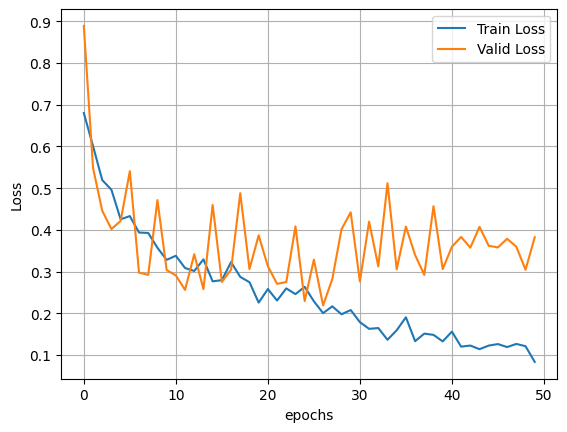

In [ ]:
history = pd.DataFrame.from_dict(history)
history.to_csv("history.csv", index=False)
plt.plot( range(history.shape[0]), history["Train Loss"].values, label="Train Loss")
plt.plot( range(history.shape[0]), history["Valid Loss"].values, label="Valid Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

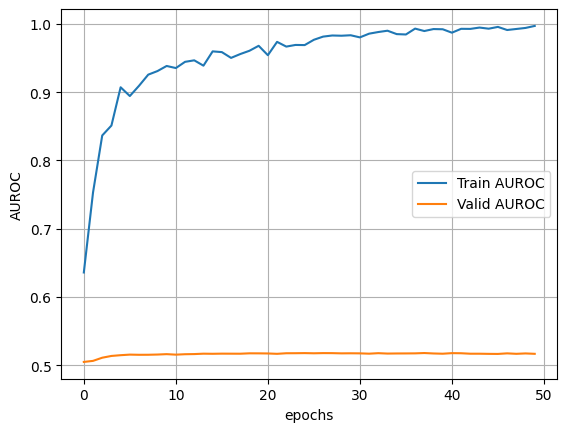

In [ ]:
plt.plot( range(history.shape[0]), history["Train AUROC"].values, label="Train AUROC")
plt.plot( range(history.shape[0]), history["Valid AUROC"].values, label="Valid AUROC")
plt.xlabel("epochs")
plt.ylabel("AUROC")
plt.grid()
plt.legend()
plt.show()

### Handmade Boosting


In [ ]:
# PATH = "/content/drive/My Drive/isic_model.pth"  # Adjust the path as needed
# torch.save(model.state_dict(), PATH)
# print(f"Model saved to Google Drive at {PATH}")

Mounted at /content/drive
Model saved to Google Drive at /content/drive/My Drive/isic_model.pth


In [60]:
model = ISICModel(model_name="efficientnet_b0", pretrained=True) # Instantiate the model with a valid model name
PATH = "/content/drive/My Drive/isic_model.pth"
model.load_state_dict(torch.load(PATH))  # Load the saved state dictionary
model.to(CONFIG['device'])  # Move the model to the desired device
model.eval()  # Set the model to evaluation mode
print("Model loaded from Google Drive.")


Model loaded from Google Drive.


In [112]:
# For test, use sample ISIC_0157834 (not a lesion) and eval
import cv2
import torch
from torchvision import transforms

# 画像のパス
img_path = "/kaggle/input/isic-2024-challenge/train-image/image/ISIC_0157834.jpg"

# 画像の前処理を定義 (必要に応じて適宜調整)
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # モデルに合わせたサイズに変更
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 画像の読み込みと前処理
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = preprocess(img).unsqueeze(0)  # バッチ次元を追加

# モデルを使って予測
with torch.no_grad():
    img = img.to(CONFIG['device'])  # 画像をデバイスに移動
    output = model(img)  # 予測

# 出力結果を表示
print("Model output:", output)
df_train.loc["ISIC_0157834"][["target","lesion_id"]]


Model output: tensor([[0.9297]])


,ISIC_0157834
target,1
lesion_id,IL_2429082


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm  # 進捗表示のために追加

# ISICDatasetとISICDataset_for_Trainは以前の実装コードを使用

class ISICDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.targets = df['target'].values
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = self.targets[index]

        if self.transforms:
            img = self.transforms(image=img)["image"]

        return {
            'image': img,
            'target': target
        }


# バッチ処理で予測結果を取得する関数
def predict_all_batches(model, df_train, batch_size=32):
    model.eval()
    predictions = []
    img_paths = [f"/kaggle/input/isic-2024-challenge/train-image/image/{isic_id}.jpg" for isic_id in df_train.index]

    # tqdm を使用して進捗バーを表示
    for i in tqdm(range(0, len(img_paths), batch_size), desc="Processing Batches"):
        batch_paths = img_paths[i:i+batch_size]
        batch_images = []
        for img_path in batch_paths:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = preprocess(img)
            batch_images.append(img)

        batch_images = torch.stack(batch_images).to(CONFIG['device'])
        with torch.no_grad():
            output = model(batch_images)
            preds = torch.sigmoid(output).cpu().numpy()
            predictions.extend(preds)

    return np.array(predictions).squeeze()

# モデルで予測を実行し、誤った予測を抽出
predictions = predict_all_batches(model, df_train)
df_train['predictions'] = predictions

# 誤った予測を持つデータを抽出
incorrect_df = df_train[(df_train['predictions'] > 0.5) != (df_train['target'] == 1)]

# 新しいデータローダの作成
class IncorrectPredictionsDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.targets = df['target'].values
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = self.targets[index]

        if self.transforms:
            img = self.transforms(image=img)["image"]

        return {
            'image': img,
            'target': target
        }

incorrect_dataset = IncorrectPredictionsDataset(incorrect_df, transforms=your_transforms)  # 既存のtransformsを使用
incorrect_dataloader = DataLoader(incorrect_dataset, batch_size=32, shuffle=True)


Processing Batches:   1%|▏         | 185/12534 [01:44<1:57:36,  1.75it/s]

In [ ]:
import torch

# モデルの評価とミス分類データの特定
misclassified_data = []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:  # 検証用データを使用
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        misclassified = (preds != labels).nonzero(as_tuple=True)[0]
        misclassified_data.extend([(images[i], labels[i]) for i in misclassified])


NameError: name 'val_loader' is not defined

In [ ]:
import torchvision.transforms as transforms
from PIL import Image, ImageEnhance

# フィルタの定義
def apply_filters(image):
    pil_image = transforms.ToPILImage()(image)

    # 色彩強調フィルタ
    enhancer = ImageEnhance.Color(pil_image)
    enhanced_image = enhancer.enhance(2.0)  # 色彩を強調

    # エッジ抽出＆強調フィルタ
    edge_image = enhanced_image.filter(ImageFilter.FIND_EDGES)
    edge_image = edge_image.filter(ImageFilter.EDGE_ENHANCE_MORE)

    return transforms.ToTensor()(edge_image)

# ミス分類データにフィルタを適用
filtered_data = [(apply_filters(img), label) for img, label in misclassified_data]


NameError: name 'misclassified_data' is not defined

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# フィルタを適用したデータセットを作成
filtered_images, filtered_labels = zip(*filtered_data)
filtered_dataset = TensorDataset(torch.stack(filtered_images), torch.tensor(filtered_labels))
filtered_loader = DataLoader(filtered_dataset, batch_size=32, shuffle=True)

# 別のモデルでトレーニング
model2 = Model()  # 新しいモデルインスタンス
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)

for epoch in range(10):
    model2.train()
    for images, labels in filtered_loader:
        optimizer2.zero_grad()
        outputs = model2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer2.step()


NameError: name 'filtered_data' is not defined

In [ ]:
# 最終モデルの予測と統合
final_predictions = []
model.eval()
model2.eval()

with torch.no_grad():
    for images in test_loader:
        outputs1 = model(images)
        outputs2 = model2(images)

        # 加重平均や他のアンサンブル手法を使用
        final_output = (outputs1 + outputs2) / 2
        _, final_pred = torch.max(final_output, 1)
        final_predictions.extend(final_pred.cpu().numpy())


## Prepare for Unsamble

In [ ]:
model1 = model
model1.load_state_dict(torch.load("model1.pth"))
model1.eval()

model2 = model
model2.load_state_dict(torch.load(model2_path

In [ ]:
# Read the CSV file
oof_image_net_preds = pd.read_csv("/kaggle/input/isic-2024-imagenet-gen-2-output/oof_predictions.csv")

# Rename the 'oof_prediction' column to 'imagenet_predict'
image_pred_col = "imagenet_predict"
oof_image_net_preds = oof_image_net_preds.rename(columns={'oof_prediction': image_pred_col})

# Merge with df_train on 'isic_id', adding both 'fold' and the prediction column
df_train = df_train.merge(oof_image_net_preds[['isic_id', 'fold', image_pred_col]],
                          on='isic_id',
                          how='left')

# Add the new column to feature_cols
feature_cols.append(image_pred_col)

# Print some information about the merged dataframe
print(f"Shape of df_train after merge: {df_train.shape}")
print(f"Number of null values in {image_pred_col}: {df_train[image_pred_col].isnull().sum()}")
print(f"Number of null values in fold: {df_train['fold'].isnull().sum()}")
print(f"Unique values in fold: {df_train['fold'].unique()}")

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/isic-2024-imagenet-gen-2-output/oof_predictions.csv'

In [ ]:
df_train

,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,onehot_37,onehot_38,onehot_39,onehot_40,onehot_41,onehot_42,onehot_43,onehot_44,onehot_45,onehot_46
isic_id,,,,,,,,,,,,,,,,,,,,,
ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,16.261975,...,0,0,0,0,0,0,0,1,0,0
ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,25.364740,...,0,0,0,0,0,0,0,1,0,0
ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,17.128170,...,1,0,0,0,0,0,0,1,0,0
ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,12.164757,...,0,1,0,1,0,0,0,0,0,0
ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,20.057470,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,14.944666,...,0,1,0,0,1,0,0,0,0,0
ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,16.026870,...,1,0,0,0,0,0,0,1,0,0
ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,12.364397,...,0,1,0,0,0,0,1,0,0,0


# ImageNet inference code

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from tqdm import tqdm
import h5py
import timm
from torchvision import transforms
from PIL import Image
import io
import albumentations as A
from albumentations.pytorch import ToTensorV2

epoch_for_preds = 1
model_path = "/kaggle/input/isic-2024-imagenet-train-oof-preds-public/"

class ISICDataset(Dataset):
    def __init__(self, hdf5_file, isic_ids, targets=None, transform=None):
        self.hdf5_file = h5py.File(hdf5_file, 'r')  # Keep file open
        self.isic_ids = isic_ids
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.isic_ids)

    def __getitem__(self, idx):
        img_bytes = self.hdf5_file[self.isic_ids[idx]][()]
        img = Image.open(io.BytesIO(img_bytes))
        img = np.array(img)

        if self.transform:
            transformed = self.transform(image=img)
            img = transformed['image']

        target = self.targets[idx] if self.targets is not None else torch.tensor(-1)
        return img, target

    def __del__(self):
        self.hdf5_file.close()  # Ensure file is closed when object is destroyed

# Define the albumentations transformation
base_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

def setup_model(num_classes=2):
    return timm.create_model('tf_efficientnetv2_b1', pretrained=False, num_classes=num_classes)

def load_models(folds, device):
    models = []
    for fold in folds:
        model = setup_model().to(device)
        model.load_state_dict(torch.load(f'{model_path}model_fold_{fold}_epoch_{epoch_for_preds}.pth', map_location=device))
        model.eval()
        models.append(model)
    return models

@torch.no_grad()  # Apply no_grad to the entire function
def ensemble_predict(models, test_loader, device):
    all_predictions = []
    for inputs, _ in tqdm(test_loader, desc="Predicting"):
        inputs = inputs.to(device)
        fold_predictions = torch.stack([model(inputs).softmax(dim=1)[:, 1] for model in models])
        avg_predictions = fold_predictions.mean(dim=0)
        all_predictions.extend(avg_predictions.cpu().numpy())
    return all_predictions


# Do ImageNet inference on test data / merge df_test

In [ ]:
TEST_HDF5_FILE_PATH = '/kaggle/input/isic-2024-challenge/test-image.hdf5'

# Set up CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# folds to use for pred
folds = [0, 1, 2, 3, 4]

models = load_models(folds, device)

# Prepare your test dataset
test_dataset = ISICDataset(
    hdf5_file=TEST_HDF5_FILE_PATH,
    isic_ids=df_test.index.values,  #minor change here from
    transform=base_transform,
)

# Create test data loader
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=4, pin_memory=True)

# Run predictions
predictions = ensemble_predict(models, test_loader, device)

# Create a new DataFrame with predictions
temp_df = pd.DataFrame({image_pred_col: predictions}, index=df_test.index)

# Join the predictions to df_test
df_test = df_test.join(temp_df)


Using device: cpu


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/isic-2024-imagenet-train-oof-preds-public/model_fold_0_epoch_1.pth'

### Optuna HyperParam Tuned Models

In [ ]:
lgb_params = {
    'objective':        'binary',
    'verbosity':        -1,
    'n_iter':           200,
    'boosting_type':    'gbdt',
    'random_state':     seed,
    'lambda_l1':        0.08758718919397321,
    'lambda_l2':        0.0039689175176025465,
    'learning_rate':    0.03231007103195577,
    'max_depth':        4,
    'num_leaves':       103,
    'colsample_bytree': 0.8329551585827726,
    'colsample_bynode': 0.4025961355653304,
    'bagging_fraction': 0.7738954452473223,
    'bagging_freq':     4,
    'min_data_in_leaf': 85,
    'scale_pos_weight': 2.7984184778875543,
}

lgb_model = Pipeline([
    ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=seed)),
    ('classifier', lgb.LGBMClassifier(**lgb_params)),
])

In [ ]:
cb_params = {
    'loss_function':     'Logloss',
    'iterations':        200,
    'verbose':           False,
    'random_state':      seed,
    'max_depth':         7,
    'learning_rate':     0.06936242010150652,
    'scale_pos_weight':  2.6149345838209532,
    'l2_leaf_reg':       6.216113851699493,
    'subsample':         0.6249261779711819,
    'min_data_in_leaf':  24,
    'cat_features':      cat_cols,
}

cb_model = Pipeline([
    ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=seed)),
    ('classifier', cb.CatBoostClassifier(**cb_params)),
])

In [ ]:
xgb_params = {
    'enable_categorical': True,
    'tree_method':        'hist',
    'random_state':       seed,
    'learning_rate':      0.08501257473292347,
    'lambda':             8.879624125465703,
    'alpha':              0.6779926606782505,
    'max_depth':          6,
    'subsample':          0.6012681388711075,
    'colsample_bytree':   0.8437772277074493,
    'colsample_bylevel':  0.5476090898823716,
    'colsample_bynode':   0.9928601203635129,
    'scale_pos_weight':   3.29440313334688,
}

xgb_model = Pipeline([
    ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=seed)),
    ('classifier', xgb.XGBClassifier(**xgb_params)),
])

In [ ]:
estimator = VotingClassifier([
    ('lgb', lgb_model), ('cb', cb_model), ('xgb', xgb_model),
], voting='soft')

### Cross Validation
* Using folds from OOF ImageNet predictions

In [ ]:
from sklearn.model_selection import PredefinedSplit

# Assuming df_train already has a 'fold' column with values 0-4
X = df_train[feature_cols]
y = df_train[target_col]

# Create a PredefinedSplit object using the 'fold' column
fold_indices = df_train['fold'].values
cv = PredefinedSplit(fold_indices)

# Perform cross-validation
val_score = cross_val_score(
    estimator=estimator,
    X=X, y=y,
    cv=cv,
    scoring=custom_metric,
)

np.mean(val_score), val_score

### Training

In [ ]:
X, y = df_train[feature_cols], df_train[target_col]

estimator.fit(X, y)

### Prediction

In [ ]:
df_subm['target'] = estimator.predict_proba(df_test[feature_cols])[:, 1]

df_subm.to_csv('submission.csv')
df_subm.head()